## Loading and Prepping the Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv('data/phonemeData.txt', sep='\t', header=None)

In [19]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,727,728,729,730,731,732,733,734,735,736
0,1,Hadza,hts,hts-TZA,Khoisan,800,Africa,-3.47684,34.79905,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Sandawe,sad,sad-TZA,Khoisan,40000,Africa,-5.28543,35.46569,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Qxu^,knw,knw-NAM,Khoisan,1760,Africa,-19.47014,18.35209,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Qxu^,ktz,ktz-NAM,Khoisan,28600,Africa,-19.76648,20.09317,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Qxu^,ktz,ktz-NAM,Khoisan,28600,Africa,-19.76648,20.09317,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
#Rename the columns cleanly
newColumns = data.columns.tolist()

newColumns[0] = "Language Number"
newColumns[1] = "Name"
newColumns[2] = "ISO Code"
newColumns[3] = "ISO A3 Code"
newColumns[4] = "Language Classification"
newColumns[5] = "Speaking Pop Size"
newColumns[6] = "Geographic Region"
newColumns[7] = "Latitude"
newColumns[8] = "Longitude"
for i in range(728):
    startPhonemeIndex = 9
    newColumns[startPhonemeIndex + i] = "Phoneme " + str(i)

#newColumns

In [88]:
data.columns = newColumns
data.head()

,Language Number,Name,ISO Code,ISO A3 Code,Language Classification,Speaking Pop Size,Geographic Region,Latitude,Longitude,Phoneme 0,...,Phoneme 718,Phoneme 719,Phoneme 720,Phoneme 721,Phoneme 722,Phoneme 723,Phoneme 724,Phoneme 725,Phoneme 726,Phoneme 727
0,1,Hadza,hts,hts-TZA,Khoisan,800,Africa,-3.47684,34.79905,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Sandawe,sad,sad-TZA,Khoisan,40000,Africa,-5.28543,35.46569,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Qxu^,knw,knw-NAM,Khoisan,1760,Africa,-19.47014,18.35209,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Qxu^,ktz,ktz-NAM,Khoisan,28600,Africa,-19.76648,20.09317,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Qxu^,ktz,ktz-NAM,Khoisan,28600,Africa,-19.76648,20.09317,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#Remove duplicates
data = data.drop_duplicates(keep = False, subset=data.columns.difference(['Language Number']))

In [69]:
#About 10 rows were duplicates
data.shape

(2072, 737)

Notes: https://www.ethnologue.com
is where you can paste in the ISO code to see that it's a real language, the "Name" column that is provided might not be super accurate

## Similarity Metrics

### Hamming Distance

### Levenshtein Distance

This is the number of edits (insert, delete, replace) required to convert one string into another. The lower the score, the less edits needed (and "more similar" the languages are by phoneme)

In [219]:
#Using Buka xuu-NAM as a root point language, slightly arbitrary but it's from Botswana, where its suggested the first people came from
#1:Compute Levenshtein Distance for every language in relation to Buka
#2: Map the language to tuple (latitude, longitude) and keep this in order of most similar to least similar
#4: do visualization from root and just keep going outwards. if there is a set of langiages that is a tie, how do we know what root the next language should branch out of?
    # Let's imagine the visualization just extends stepwise, so every step the new set of points are added on the map, like level 0, level 1, 2, etc.
bukaRow = data.loc[data['Name'] == "Buka"]
bukaRow = bukaRow.iloc[:, 9:]

#A list of the phoneme values
bukaRowList = list(bukaRow.values[0])
#print(bukaRowList)

levenshteinDistanceMapToBukaRoot = {}

In [220]:
#Taken from Google Gemini AI
def levenshtein_distance(list1, list2):
  len1 = len(list1)
  len2 = len(list2)

  # Handle empty list cases
  if len1 == 0:
    return len2
  if len2 == 0:
    return len1

  # Create a DP table to store subproblem solutions
  dp = [[0 for _ in range(len2 + 1)] for _ in range(len1 + 1)]

  # Initialize first row and column for base cases
  for i in range(len1 + 1):
    dp[i][0] = i
  for j in range(len2 + 1):
    dp[0][j] = j

  # Fill the DP table
  for i in range(1, len1 + 1):
    for j in range(1, len2 + 1):
      cost = 0 if list1[i - 1] == list2[j - 1] else 1
      dp[i][j] = min(dp[i - 1][j] + 1,  # Deletion
                     dp[i][j - 1] + 1,  # Insertion
                     dp[i - 1][j - 1] + cost)  # Substitution

  # Return the Levenshtein distance from the bottom right corner
  return dp[len1][len2]



In [221]:
#Takes 10.5 minutes to run at home, 17 minutes on campus
for index, row in data.iterrows():
    #print(index)

    #We actually want to include the base root in this map because it'll have 
    #perfect score and be our first value (root)

    languageName = row['Name']
    languagePhonemes = row.iloc[9:]
    #print(languagePhonemes)
    languagePhonemesList = list(languagePhonemes.values)
    levenshteinDistance = levenshtein_distance(bukaRowList, languagePhonemesList)
    #print(f"Levenshtein Distance between lists: {levenshteinDistance}")

    levenshteinDistanceMapToBukaRoot[languageName] = levenshteinDistance


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [223]:
languageLocations = {}
for index, row in data.iterrows():
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    languageName = row["Name"]
    languageLocations[languageName] = (latitude, longitude)
    #print(index)

# Sort the levenshteinDistanceMapToBukaRoot dictionary by values (scores)
sortedLanguages = sorted(levenshteinDistanceMapToBukaRoot, key=lambda x: levenshteinDistanceMapToBukaRoot[x])

In [224]:
# Group languages by their scores
groupedLanguages = {}
for lang in sortedLanguages:
    score = levenshteinDistanceMapToBukaRoot[lang]
    if score in groupedLanguages:
        groupedLanguages[score].append(lang)
    else:
        groupedLanguages[score] = [lang]

# Create a 2D list where each sublist contains languages with the same score
orderedLanguageLocations = []
for score in sorted(groupedLanguages.keys()):
    orderedLanguageLocations.append([(lang, languageLocations[lang]) for lang in groupedLanguages[score]])



In [231]:
#This shows the scores mapped to the languages, sorted
print(groupedLanguages)

{0: ['Handa'], 16: ['G/wi'], 20: ['G//ana', 'Naron'], 21: ['Xu^'], 29: ['!Ora'], 33: ['Danisin'], 35: ['\\u450?Hu^'], 37: ['Nama'], 38: ['Shua'], 40: ['Deti'], 43: ['N/huki'], 46: ['Sandawe'], 48: ['G//abake', 'Ndebele'], 51: ['Borunca'], 52: ['Garo', 'Chimbu', 'Aghu', 'Isleta'], 53: ['Kela', 'Kejia', 'Siocon Subanon', 'Matukar', 'Nehan', 'Sawuy', 'Pisa', 'Awin', 'Gogodala', 'Moni', 'Suena', 'Cuiba'], 54: ['Southern Min', 'Tonsawang', 'Kadazan-Dusun', 'Manam', 'Megiar', 'Gedaged', 'Kehelala', 'Bileki', 'Seimat', 'Kusunda', 'Morwap', 'Yaknge', 'Burum', 'Asienara', 'Siagha', 'Pa', 'Nomad', 'Bainapi', 'Mombum', 'Warkay', 'Zia', 'Waskia', 'Maklew', 'Dera', 'Taikat', 'Wogamusin', 'Tatuyo', 'Galibi'], 55: ['Sane', 'Assamese', 'Wu', 'Sunwar', 'Mikir', 'Kenta Bong', 'Yogad', 'Umiray Dumaget', 'Casiguran Dumagat', 'Central Kalinga', 'Central Ifugao', 'Binukid', 'Ata', 'Buhid', 'Kolod', 'Timugon', 'Eastern Kadazan', 'Yakan', 'Toba Batak', 'Suau', 'Duke of York', 'Whitesands', 'Oksapmin', 'Kovai'

In [225]:
#This gives an ordered list containing the tuple of (language, location)
    #location itself is tuple of (latitude, longitude)
#If multiple items are in the same list index, that means they have the same score
#and should be visualized (plotted) at the same time step
print(orderedLanguageLocations)

[[('Handa', (-19.06392, 22.96317))], [('G/wi', (-22.29781, 22.0585))], [('G//ana', (-21.7807, 22.31348)), ('Naron', (-22.1784, 21.57212))], [('Xu^', (-17.65705, 22.41191))], [('!Ora', (-30.42065, 19.77108))], [('Danisin', (-20.72794, 26.26589))], [('\\u450?Hu^', (-23.94004, 24.76275))], [('Nama', (-29.48691, 17.83793))], [('Shua', (-20.72794, 26.26589))], [('Deti', (-20.72794, 26.26589))], [('N/huki', (-29.70543, 19.08408))], [('Sandawe', (-5.28543, 35.46569))], [('G//abake', (-21.8594, 26.06263)), ('Ndebele', (-19.70768, 28.68473))], [('Borunca', (8.88129, -83.20706))], [('Garo', (25.57927, 90.51116)), ('Chimbu', (-6.27165, 145.02852)), ('Aghu', (-6.34522, 140.09942)), ('Isleta', (34.90035, -106.63952))], [('Kela', (-7.38913, 147.13144)), ('Kejia', (24.85862, 114.68195)), ('Siocon Subanon', (7.73572, 122.37053)), ('Matukar', (-4.90623, 145.77936)), ('Nehan', (-4.53527, 154.23329)), ('Sawuy', (-5.99013, 138.66952)), ('Pisa', (-6.00189, 139.14305)), ('Awin', (-5.81547, 141.47911)), ('Go

## Visualization 

In [ ]:
#This is just a chatgpt example, should we try to work this to fit our data?

In [9]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scattergeo plot for the initial locations
scatter = fig.add_trace(
    go.Scattergeo(
        mode='markers+text',
        textposition='top center',
        #marker=dict(
        #    size=10,
        #    color='blue',
        #    opacity=0.7,
        #),
        name='Cities'
    )
)

# Set initial layout properties
fig.update_layout(
    title='Spread of Languages by Phoneme',
    geo=dict(
        scope='world',
        showland=True,
    )
)

# Add frames for animation
frames = []
locations_list = [
    [(40.7128, -74.0060), (51.5074, -0.1278), (-33.8688, 151.2093)],  # Example locations for 1952
    [(37.7749, -122.4194), (48.8566, 2.3522), (-37.8136, 144.9631)],  # Example locations for 1953
    [(34.0522, -118.2437), (55.7558, 37.6176), (35.6895, 139.6917)]   # Example locations for 1954
]


all_locations = []
for i, locations in enumerate(locations_list):
    all_locations.extend(locations)
    frame_data = go.Frame(
        data=[
            go.Scattergeo(
                lon=[loc[1] for loc in all_locations],
                lat=[loc[0] for loc in all_locations],
                mode='markers+text',
                textposition='top center',
                marker=dict(
                    size=10,
                    color='blue',
                    opacity=0.7,
                )
            )
        ],
    )
    frames.append(frame_data)

# Add frames to the figure
fig.frames = frames

# Update animation settings
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True, "mode": "immediate"}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
)

# Show the plot
fig.show()


## Clustering Analysis

In [144]:
unique_values_count = data['Language Classification'].nunique()

print("Number of unique values in the 'ICO' column:", unique_values_count)

Number of unique values in the 'ICO' column: 102


In [145]:
#For every unique language classification, we want to isolate those rows.
#take the majority phoneme value for each phoneme, (ie if 9/10 have 1 for phoneme 0, then it's a 1)
#using Khoisan as root (because of Buka, and also a different one to countertest it),
    #make a dendrogram? using hamming distance. this should validate our visualization



In [146]:
treeData = data

# Now let's find the majority value for each Language Classification
def majority_value(group):
    phoneme_cols = [col for col in group.columns if col.startswith('Phoneme')]
    majority_row = {}
    for col in phoneme_cols:
        value_counts = group[col].value_counts()
        #print(value_counts)
        # Get the value with the highest count
        majority_value = value_counts.idxmax()
        #print(majority_value)
        # Store the majority value for the column
        majority_row[col] = majority_value
    return pd.Series(majority_row)

# Group by Language Classification and apply the majority_value function
groupedTreeData = treeData.groupby('Language Classification').apply(majority_value).reset_index()

print(groupedTreeData)

    Language Classification  Phoneme 0  Phoneme 1  Phoneme 2  Phoneme 3  \
0              Afro-Asiatic          0          0          0          0   
1                Alacalufan          0          0          0          0   
2                     Algic          0          0          0          0   
3                    Altaic          0          0          0          0   
4                Andamanese          0          0          0          0   
..                      ...        ...        ...        ...        ...   
97                Yeniseian          0          0          0          0   
98                 Yukaghir          0          0          0          0   
99                     Yuki          0          0          0          0   
100                Zamucoan          0          0          0          0   
101                Zaparoan          0          0          0          0   

     Phoneme 4  Phoneme 5  Phoneme 6  Phoneme 7  Phoneme 8  ...  Phoneme 718  \
0            0     

In [147]:
#result.head()
if (groupedTreeData.iloc[5] == 1).any():
    print("At least one value in the row is equal to 1.")
else:
    print("No value in the row is equal to 1.")

At least one value in the row is equal to 1.


In [148]:
groupedTreeData.shape

(102, 729)

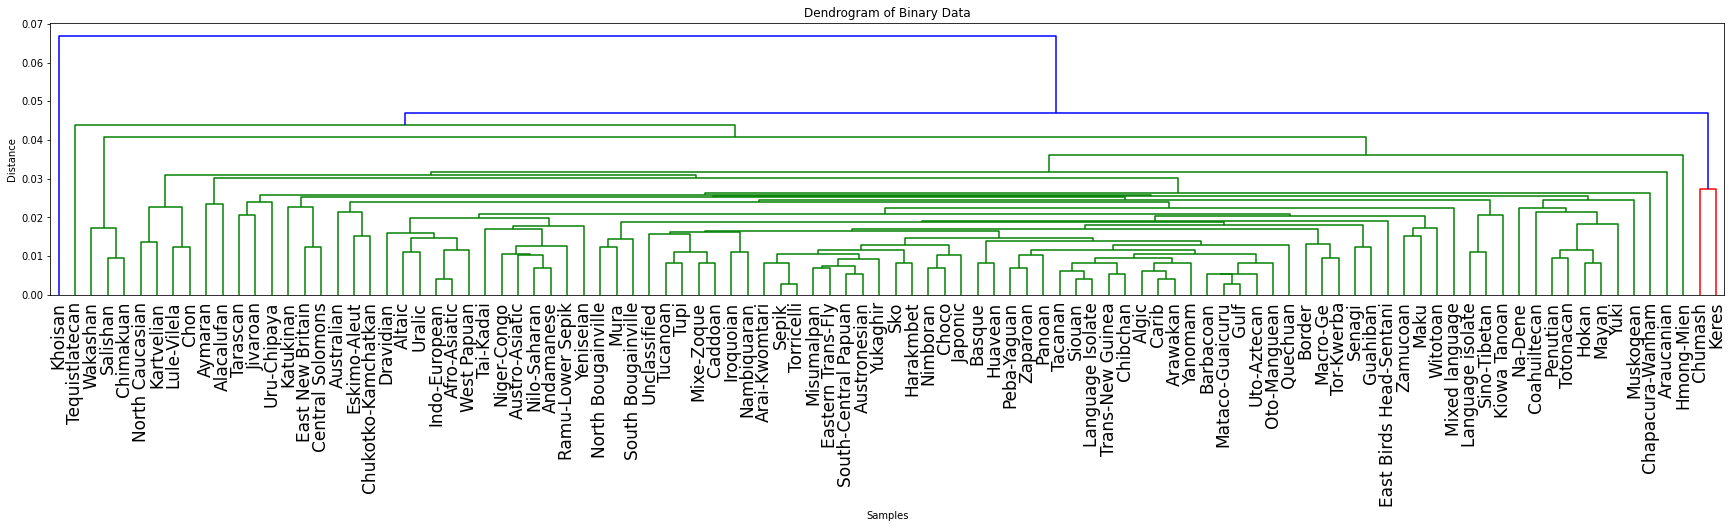

In [180]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

binary_data = groupedTreeData.iloc[:, 1:].values  # Assuming binary data starts from column 1

distance_matrix = hierarchy.distance.pdist(binary_data, metric='hamming')

Z = hierarchy.linkage(distance_matrix, method='average', optimal_ordering=True)

# Plot dendrogram
plt.figure(figsize=(30, 5))
dn = hierarchy.dendrogram(Z, labels=groupedTreeData.iloc[:, 0].values, leaf_rotation=90)
plt.title('Dendrogram of Binary Data')
plt.xlabel('Samples')
plt.xticks(fontsize=17, rotation=90)
plt.ylabel('Distance')
plt.show()
